# Select useful data and output in graphs

In [1]:
import pandas as pd
import glob

## Automatically select input files from current folder

In [2]:
files_with_raw_data = []

for file in glob.glob("*.csv"):
    if "raw" in file and "out" not in file:
        files_with_raw_data.append(file)
        print(file)
    elif "raw_out" in file:
        file_data_raw_out = file
        print(file)
    elif "pipetting_out" in file:
        file_data_pipetting_out = file
        print(file)

for file in glob.glob("*.xlsx"):
    if "mtp_design" in file:
        file_mtp_design = file
        print(file)

MF_2021_W08_pipetting_out.csv
MF_2021_W08_raw.csv
MF_2021_W08_raw_out.csv
MF_2021_W08_mtp_design.xlsx


## Import raw measurement data

In [3]:
df = pd.read_csv(file_data_raw_out, delimiter=";", index_col=False, low_memory=False)

In [4]:
df.head()

,Type,Cycle,Well,Filterset,Time,Amp_1,Amp_2,AmpRef_1,AmpRef_2,Phase,...,P_LC_peltier,P_WB_heating_rod,T_UC_HumSensor_digital,T_CO2,X-Pos,Y-Pos,T_LED,Ref_Int,Ref_Phase,Ref_Gain
0,M,1,1,1,40,12.08,0.0,11.63,0.0,-2.31,...,63.5,80.0,26.91,-1000.0,-103.8,-69.832,32,2901.67,73.96,3
1,M,1,2,1,41,11.93,0.0,11.48,0.0,-2.45,...,60.5,80.0,26.91,-1000.0,-90.8,-69.832,32,2901.17,73.94,3
2,M,1,3,1,43,12.07,0.0,11.61,0.0,-2.43,...,60.5,80.0,26.91,-1000.0,-77.8,-69.832,32,2900.99,73.95,3
3,M,1,4,1,44,21.19,0.0,20.39,0.0,-2.58,...,57.0,80.0,26.92,-1000.0,-64.8,-69.832,32,2901.00,73.92,3
4,M,1,5,1,45,20.15,0.0,19.39,0.0,-2.55,...,53.0,80.0,26.92,-1000.0,-64.8,-56.872,32,2900.66,73.93,3


## Find the process settings chosen by the user

In [5]:
# Select the required data for the settings
interesting_parameters = {}

with open(files_with_raw_data[0]) as file:
    while line := file.readline(): 
        if line.startswith("["):
            line_clean = line.replace("\n", "").replace(" ", "").replace("[", "")
            line_split = line_clean.split("]")
            interesting_parameters[line_split[0]] = line_split[1]

In [6]:
# Find interesting process parameters
keys_to_extract = ["start_date_time", "end_date_time", "name", "user", "comment", "mtp", "mtp-rows", "mtp-columns", "mtp-lot", "no_filterset", "temperature", "humidity", "frequency", "cycle-time"]
process_parameters = {key: interesting_parameters[key] for key in keys_to_extract}
#process_parameters

## Select filter data

In [7]:
# Select filter data
filter_keys = ['filter_no', 'filter_name', 'filter_id', 'gain']
dict_filters = {i: [] for i in filter_keys}

for parameter in interesting_parameters:
    if parameter.endswith('_no'):
        dict_filters['filter_no'].append(interesting_parameters[parameter])
    if parameter.endswith('_name'):
        dict_filters['filter_name'].append(interesting_parameters[parameter])
    if parameter.endswith('_filter_id'):
        dict_filters['filter_id'].append(interesting_parameters[parameter])
    if parameter.endswith('_gain_1'):
        dict_filters['gain'].append(interesting_parameters[parameter])

In [8]:
df_filters = pd.DataFrame(dict_filters, columns = filter_keys)

In [9]:
df_filters

,filter_no,filter_name,filter_id,gain
0,1,Biomass(4),401,4
1,2,Biomass(8),401,8
2,3,Doxorubicin(9),447,9
3,4,Doxorubicin(13,447,13
4,5,pH(LG1),421,8
5,6,DO(RF),428,4


In [10]:
# What are the filter_no for pH and DO? (They should be plotted differently)
if "pH(LG1)" in list(df_filters["filter_name"]):
    filter_no_pH = int(df_filters[df_filters["filter_name"] == "pH(LG1)"]["filter_no"].iloc[0])
else:
    filter_no_pH = "None"
    print("No pH filter")

if "DO(RF)" in list(df_filters["filter_name"]):
    filter_no_DO = int(df_filters[df_filters["filter_name"] == "DO(RF)"]["filter_no"].iloc[0])
else:
    filter_no_DO = "None"
    print("No DO filter")

## Import well design

In [11]:
# Collect well map from excel file and read into dataframe
df_design = pd.read_excel(file_mtp_design)

# Find which well number in raw data df corresponds to each well_code in df_design
well_codes_raw = []
well_nos_raw = []
counter = 1

for parameter in interesting_parameters:
    if parameter.endswith("well"):
        well_codes_raw.append(interesting_parameters[parameter])
        well_nos_raw.append(counter)
        counter += 1

In [12]:
well_codes_dict = dict(zip(well_codes_raw, well_nos_raw))

In [13]:
# Add well number to design dataframe
well_code_ordered = []

for code in df_design["well_code"]:
    well_code_ordered.append(well_codes_dict[code])

df_design.insert(1, 'well_no', well_code_ordered)

In [14]:
df_design.head()

,well_code,well_no,strain,medium,sample
0,A01,1,M145,F134,31
1,B01,8,M145,F134,31
2,C01,9,M145,F134,31
3,D01,16,M145,F134,50
4,E01,17,M145,F134,50


## Add well design to measurement df

In [15]:
# Convert well design dataframe to dictionary based on the well number
dict_design = df_design.set_index("well_no").to_dict()

# Find all design categories that should be added to the dataframe
design_categories = list(df_design.columns)
design_categories.remove("well_no")

# Add a column for each category to the dataframe
for category in design_categories:
    df[category] = df[df["Well"].notnull()]["Well"].apply( lambda x: dict_design[category][x])

## Add filter data to measurement df

In [16]:
# Rearrange dictionary of filters
dict_filters_2 = df_filters.set_index("filter_no").to_dict()

# Add a column for filter data to the dataframe
df["filter_name"] = df[df["Filterset"].notnull()]["Filterset"].apply( lambda x: dict_filters_2["filter_name"][str(int(x))])

## Import raw pipetting data

In [17]:
df_pip = pd.read_csv(file_data_pipetting_out, delimiter=";", index_col=False, low_memory=False)

In [18]:
df_pip.head()

,Date,Runtime[h],Cycle No.,Well,Trigger,Source,Destination,Volume,Mode,Tip
0,25/02/2021,"22,1052777777778",89,C03,Add acid 1M (pH),Slot1:1,BioLector:C03,2,Dosing,Fixed
1,25/02/2021,"22,1052777777778",89,E03,Add acid 1M (pH),Slot1:1,BioLector:E03,2,Dosing,Fixed
2,25/02/2021,"22,1052777777778",89,F01,Add acid 1M (pH),Slot1:1,BioLector:F01,2,Dosing,Fixed
3,25/02/2021,"22,1052777777778",89,F03,Add acid 1M (pH),Slot1:1,BioLector:F03,2,Dosing,Fixed
4,25/02/2021,"22,3533333333333",90,A01,Add acid 1M (pH),Slot1:1,BioLector:A01,2,Dosing,Fixed


## Adjust pipetting data

In [19]:
import string as string

In [20]:
# Convert the time from hours to seconds
df_pip["Runtime[h]"] = df_pip["Runtime[h]"].str.replace(',', '.').astype(float)
df_pip["Time"] = df_pip["Runtime[h]"]*3600

In [21]:
# Convert well design dataframe to dictionary based on the well code
dict_design2 = df_design.set_index("well_code").to_dict()

# Add well numbers based in the well code to the dataframe
df_pip["well_no"] = df_pip[df_pip["Well"].notnull()]["Well"].apply( lambda x: dict_design2["well_no"][x])

In [22]:
# Create dictionary of filterset and a alphabetical code
triggers = df_pip.Trigger.unique()
triggers_no = list(string.ascii_uppercase)[0:len(triggers)]
dict_triggers = {triggers[i]: triggers_no[i] for i in range(len(triggers))}

# Add "Filterset" column to identify the triggers
df_pip["Filterset"] = df_pip[df_pip["Trigger"].notnull()]["Trigger"].apply( lambda x: dict_triggers[x])

In [23]:
# Rename the columns so that they will fit into the measurement dataframe
df_pip.rename(columns={'Cycle No.': 'Cycle', 'Well': 'well_code', 'well_no': 'Well'}, inplace=True)

In [24]:
# Sort the dataframe to separate each well for each trigger and sort by cycle number
df_pip = df_pip.sort_values(["Well", "Trigger", "Cycle"])

# Combine the trigger and well columns to one column
df_pip['trigger_well'] = df_pip['Filterset'] + "_" + df_pip["Well"].astype(str)

In [25]:
# Add empty column for cumulative data
df_pip['cum_value'] = df_pip.apply(lambda _: '', axis=1)
end_time = df["Time"].max()

for trigger_well in df_pip['trigger_well'].unique():
    
    # Cumulative addition for each well for each trigger separately
    df_pip.loc[df_pip['trigger_well'] == trigger_well, "cum_value"] = df_pip[df_pip['trigger_well'] == trigger_well]["Volume"].cumsum()
    max_value = df_pip[df_pip['trigger_well'] == trigger_well]["cum_value"].max()
    
    # Identify trigger code and well code separately
    trigger_code = df_pip[df_pip["trigger_well"] == trigger_well]["Filterset"].iloc[0]
    well_code = df_pip[df_pip["trigger_well"] == trigger_well]["Well"].iloc[0]
    
    # For each well for each trigger add rows for volume = 0 at time = 0 and volume = max at time = max
    new_row_max = {"Filterset": trigger_code, "Well": well_code, "trigger_well": trigger_well, "Time": end_time, "cum_value": max_value}
    new_row_min = {"Filterset": trigger_code, "Well": well_code, "trigger_well": trigger_well, "Time": 0, "cum_value": 0}
    
    df_pip = df_pip.append(new_row_max, ignore_index=True)
    df_pip = df_pip.append(new_row_min, ignore_index=True)


In [26]:
df_pip = df_pip.sort_values(["Well", "Filterset", "Time"])

In [27]:
x = df_pip[(df_pip["Well"] == 32) & (df_pip["Filterset"] == "A")]["Time"]/3600
y = df_pip[(df_pip["Well"] == 32) & (df_pip["Filterset"] == "A")]["cum_value"]
#plt.plot(x, y)

## Add filter data to measurement df

In [28]:
df_pip

,Date,Runtime[h],Cycle,well_code,Trigger,Source,Destination,Volume,Mode,Tip,Time,Well,Filterset,trigger_well,cum_value
393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,A,A_1,0
0,25/02/2021,22.353333,90.0,A01,Add acid 1M (pH),Slot1:1,BioLector:A01,2.0,Dosing,Fixed,80472.0,1,A,A_1,2
1,25/02/2021,23.356111,94.0,A01,Add acid 1M (pH),Slot1:1,BioLector:A01,2.0,Dosing,Fixed,84082.0,1,A,A_1,4
2,25/02/2021,25.109167,101.0,A01,Add acid 1M (pH),Slot1:1,BioLector:A01,2.0,Dosing,Fixed,90393.0,1,A,A_1,6
3,25/02/2021,26.110278,105.0,A01,Add acid 1M (pH),Slot1:1,BioLector:A01,2.0,Dosing,Fixed,93997.0,1,A,A_1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,26/02/2021,47.660278,191.0,F01,Add acid 1M (pH),Slot1:1,BioLector:F01,2.0,Dosing,Fixed,171577.0,24,A,A_24,52
389,26/02/2021,48.910000,196.0,F01,Add acid 1M (pH),Slot1:1,BioLector:F01,2.0,Dosing,Fixed,176076.0,24,A,A_24,54
390,26/02/2021,49.160278,197.0,F01,Add acid 1M (pH),Slot1:1,BioLector:F01,2.0,Dosing,Fixed,176977.0,24,A,A_24,56
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184191.0,24,A,A_24,58


In [29]:
# df = df.append(df_pip).fillna(0)

## Output dataframe to .csv

In [30]:
file_data_out = file_data_raw_out.replace("_raw_out.csv","_summary.csv")
df.to_csv(file_data_out, encoding='utf-8', index=False)

## Plotting

In [31]:
import matplotlib.pyplot as plt
import numpy as np

## Plotting one filter per graph

In [32]:
def plotting_data(chosen_categories, chosen_filter, reduce_replicates):
    
    if reduce_replicates == "yes":
        # Select only one of each replicate -> note depends on where the replicates are in the plate!!!
        list_repr = np.arange(0, len(df_design), 3)
        list_repr = [22 if x==21 else x for x in list_repr]
        print(list_repr)
        df_design_ed = df_design.iloc[list_repr]
    else:
        df_design_ed = df_design

    # Select the categories that should be plotted
    for i in range(len(chosen_categories)):
        df_design_ed = df_design_ed[df_design_ed[categories[i]].isin(chosen_categories[i])]

    # Select wells that should be plotted
    selected_wells = df_design_ed["well_no"].tolist()
    
    # Select the data column that should be plotted
    if chosen_filter == filter_no_pH or chosen_filter == filter_no_DO:
        data_column = 'Cal'
    elif type(chosen_filter) == str:
        data_column = "cum_value"
    else:
        data_column = 'Amp_1'

    # Initiate the figure
    fig = plt.figure(figsize=(15,7))
    
    # Plot the data onto the figure
    legend = []
    max_y = 0
    
    for i in selected_wells:
        
        # Find filter data for each well that should be plotted
        x = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter)]['Time']/3600  # convert from seconds to hours
        y = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter)][data_column]
        
        # Plot the data of each well onto the graph
        plt.plot(x, y)
        
        # Make the legend description for each well
        legend_well = str(df_design[(df_design["well_no"] == i)]["well_code"].iloc[0])
        for cat in categories:
            legend_cat = df_design[(df_design["well_no"] == i)][cat].iloc[0]
            legend_well += "; " + str(legend_cat)
        legend.append(legend_well)
    
        # Determine the highest y-value in all data
        if y.empty == False:
            if max(y) > max_y:
                max_y = max(y)
    
    min_y = 0
    
    # Determine the maximum of the y-axis based on the highest y-value in all data
    if chosen_filter == filter_no_pH:
        min_y = 6
        max_y = 8
    elif chosen_filter == filter_no_DO:
        max_y = 120
    else:
        max_y = max_y + 50 - max_y % 50
#     max_y = 200
    
    # Plot the labels, legend, title and determine the axis limits
    plt.xlabel("Time (h)")
    plt.ylabel("Output")
    plt.legend(legend, bbox_to_anchor=(1.05, 1))
    plt.title(df_filters[(df_filters["filter_no"] == str(chosen_filter))]["filter_name"].iloc[0])
    plt.xlim(xmin=0)
    plt.ylim(ymin=min_y, ymax=max_y)

In [33]:
# What can be plotted?
categories = []
values = []
for i in range(2, len(df_design.columns)):
    category = list(df_design.columns)[i]
    categories.append(category)
    value_options = df_design[category].unique()
    values.append(list(value_options))

print(f"Choose data from following:\n{categories}\n{values}")

filter_names = df_filters["filter_no"].tolist()
filter_nos = df_filters["filter_name"].tolist()

print(f"Choose filter from following:\n{filter_nos}\n{filter_names}")

Choose data from following:
['strain', 'medium', 'sample']
[['M145', 'M145 -matAB', 'M1152'], ['F134', 'F134 + JA'], [31, 50]]
Choose filter from following:
['Biomass(4)', 'Biomass(8)', 'Doxorubicin(9)', 'Doxorubicin(13', 'pH(LG1)', 'DO(RF)']
['1', '2', '3', '4', '5', '6']


[0, 3, 6, 9, 12, 15, 18, 22]


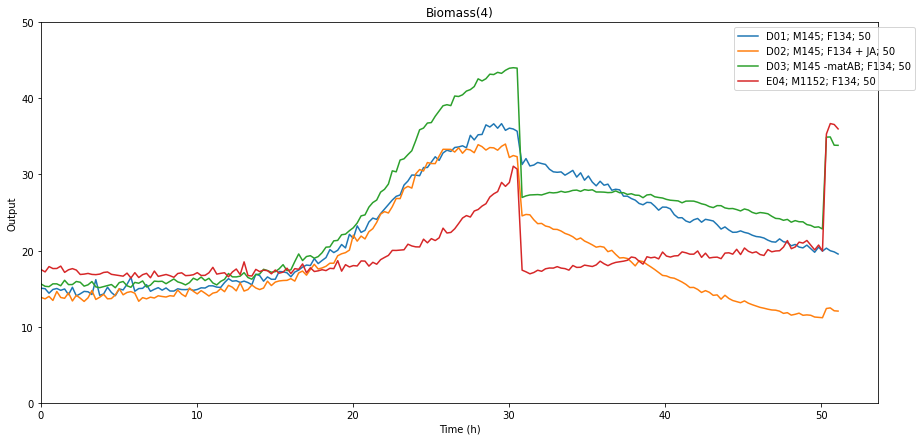

In [42]:
# Insert here what you want to plot:
plotting_data([['M145', 'M145 -matAB', 'M1152'], ['F134', 'F134 + JA'], [50]], 1, "yes")

### Plotting multiple filters per graph

In [35]:
def plotting_data2(chosen_categories, chosen_filter_1, chosen_filter_2, reduce_replicates):
    
    # Select only one of each replicate -> note depends on where the replicates are in the plate!!!
    df_design_repr = df_design
    df_design_repr = df_design_repr.iloc[np.arange(0, 47, 3)]

    if reduce_replicates == "yes":
        df_design_ed = df_design_repr
        
    else:
        df_design_ed = df_design
    
    # Select the categories that should be plotted
    for i in range(len(chosen_categories)):
        df_design_ed = df_design_ed[df_design_ed[categories[i]].isin(chosen_categories[i])]

    # Select wells that should be plotted
    selected_wells = df_design_ed["well_no"].tolist()
    
    # Initiate the figure
    fig, ax1 = plt.subplots(figsize=(15,7))
    
    # Plot the data onto the figure
    legend = []
    max_y = 0

    # Determine colors in graph:
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    counter = 0
    
    for i in selected_wells:
            
        # Select the data column that should be plotted
        if chosen_filter_1 == filter_no_pH or chosen_filter_1 == filter_no_DO:
            data_column = 'Cal'
        else:
            data_column = 'Amp_1'

        # Find filter data for each well that should be plotted
        x = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter_1)]['Time']/3600  # convert from seconds to hours
        y = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter_1)][data_column]

        # Plot the data of each well onto the graph
        ax1.plot(x, y, color=colors[counter])
        counter += 1

        # Make the legend description for each well
        legend_well = str(df_design[(df_design["well_no"] == i)]["well_code"].iloc[0])
        for cat in categories:
            legend_cat = df_design[(df_design["well_no"] == i)][cat].iloc[0]
            legend_well += "; " + str(legend_cat)
        legend.append(legend_well)

        # Determine the highest y-value in all data
        if max(y) > max_y:
            max_y = max(y)
    
    min_y = 0
    # Determine the maximum of the y-axis based on the highest y-value in all data
    if chosen_filter_1 == filter_no_pH:
        min_y = 6
        max_y = 8
    elif chosen_filter_1 == filter_no_DO:
        max_y = 120
    elif max_y < 50:
        max_y = max_y + 10 - max_y % 10   
    else:
        max_y = max_y + 50 - max_y % 50
    
    ax1_max_y = max_y
    ax1_min_y = min_y
    
    plt.legend(legend)  # , bbox_to_anchor=(1.05, 1)
    ax2 = ax1.twinx()
    
    max_y = 0
    counter = 0
    
    for i in selected_wells:
            
        # Select the data column that should be plotted
        if chosen_filter_2 == filter_no_pH or chosen_filter_2 == filter_no_DO:
            data_column = 'Cal'
        else:
            data_column = 'Amp_1'

        # Find filter data for each well that should be plotted
        x = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter_2)]['Time']/3600  # convert from seconds to hours
        y = df[(df["Well"] == i) & (df["Filterset"] == chosen_filter_2)][data_column]

        # Plot the data of each well onto the graph
        ax2.plot(x, y, '--', color=colors[counter])
        counter += 1

        # Determine the highest y-value in all data
        if max(y) > max_y:
            max_y = max(y)
    
    min_y = 0
    # Determine the maximum of the y-axis based on the highest y-value in all data
    if chosen_filter_2 == filter_no_pH:
        min_y = 6
        max_y = 8
    elif chosen_filter_2 == filter_no_DO:
        max_y = 120
    elif max_y < 50:
        max_y = max_y + 10 - max_y % 10   
    else:
        max_y = max_y + 50 - max_y % 50
    
    ax2_max_y = max_y
    ax2_min_y = min_y


    filter_1 = df_filters[(df_filters["filter_no"] == str(chosen_filter_1))]["filter_name"].iloc[0]
    filter_2 = df_filters[(df_filters["filter_no"] == str(chosen_filter_2))]["filter_name"].iloc[0]
    
    # Plot the labels, legend, title and determine the axis limits
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel(filter_1)
    ax1.set_ylim(ymin=ax1_min_y, ymax=ax1_max_y)
    ax2.set_ylabel(filter_2)
    ax2.set_ylim(ymin=ax2_min_y, ymax=ax2_max_y)
    plt.title(filter_1 + ' and ' + filter_2)
    plt.xlim(xmin=0)


In [36]:
print(f"Choose data from following:\n{categories}\n{values}")
print(f"Choose filter from following:\n{filter_nos}\n{filter_names}")

Choose data from following:
['strain', 'medium', 'sample']
[['M145', 'M145 -matAB', 'M1152'], ['F134', 'F134 + JA'], [31, 50]]
Choose filter from following:
['Biomass(4)', 'Biomass(8)', 'Doxorubicin(9)', 'Doxorubicin(13', 'pH(LG1)', 'DO(RF)']
['1', '2', '3', '4', '5', '6']


In [37]:
# Insert here what you want to plot:
plotting_data2([['G001', 'WT'], ['R5-glu', 'R5+glu'], ['no']], 3, 4, "yes")

IndexError: positional indexers are out-of-bounds